In [1]:
import numpy as np
import matplotlib.pyplot as plt

from afv.finite_voronoi import PhysicalParams, FiniteVoronoiSimulator

## Open boundary conditions

The code uses open boundary conditions.

In [2]:
np.random.seed(42)

N = 1000                    # number of cells         
L = 40                      # box size
pts = np.random.rand(N, 2)  # shape (N,2)
pts *= L

In [3]:
# Maximal radius
radius = 1.0

# Parameter set
phys = PhysicalParams(
    r=radius,
)

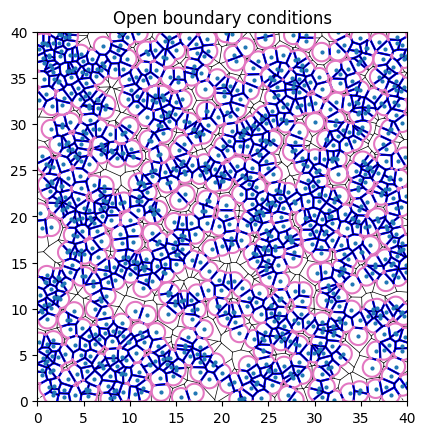

In [4]:
sim = FiniteVoronoiSimulator(pts, phys)

fig, ax = plt.subplots(dpi=100)
ax = sim.plot_2d()

ax.set_xlim(0, L)
ax.set_ylim(0, L)
ax.set_title("Open boundary conditions")

plt.show()

## Periodic boundary conditions

It's simple to achieve the periodic boundary boundary via a tiling of the edge regions (at least $2\ell$).

In [5]:
def tile_pbc_with_index(pts: np.ndarray, r: float, L: float):
    """
    Periodic tiling of pts (N,2), with bookkeeping.
    Returns:
        pos_pbc  : (M,2) tiled positions
        idx_orig : (M,) indices mapping each tiled point back to original 0..N-1
    """
    pts = np.asarray(pts)
    N = pts.shape[0]
    thresh = 2.01 * r

    x = pts[:, 0]
    y = pts[:, 1]

    # --- Stage 1: originals + left/right ---
    mask_l = x <= thresh
    mask_r = x >= (L - thresh)
    inds_l = np.flatnonzero(mask_l)
    inds_r = np.flatnonzero(mask_r)
    n_l, n_r = inds_l.size, inds_r.size

    NA = N + n_l + n_r
    pos_aug = np.empty((NA, 2), dtype=pts.dtype)
    idx_aug = np.empty(NA, dtype=np.int64)

    # originals
    pos_aug[:N] = pts
    idx_aug[:N] = np.arange(N, dtype=np.int64)
    i = N

    # left (+L, 0)
    if n_l:
        sl = slice(i, i+n_l)
        pos_aug[sl] = pts[inds_l]
        pos_aug[sl, 0] += L
        idx_aug[sl] = inds_l
        i += n_l

    # right (−L, 0)
    if n_r:
        sl = slice(i, i+n_r)
        pos_aug[sl] = pts[inds_r]
        pos_aug[sl, 0] -= L
        idx_aug[sl] = inds_r
        i += n_r

    # --- Stage 2: on augmented, append down then up ---
    y_aug = pos_aug[:, 1]
    inds_d = np.flatnonzero(y_aug <= thresh)
    inds_u = np.flatnonzero(y_aug >= (L - thresh))
    n_d, n_u = inds_d.size, inds_u.size

    M = NA + n_d + n_u
    pos_out = np.empty((M, 2), dtype=pts.dtype)
    idx_out = np.empty(M, dtype=np.int64)

    pos_out[:NA] = pos_aug
    idx_out[:NA] = idx_aug
    j = NA

    # down (0, +L)
    if n_d:
        sl = slice(j, j+n_d)
        pos_out[sl] = pos_aug[inds_d]
        pos_out[sl, 1] += L
        idx_out[sl] = idx_aug[inds_d]
        j += n_d

    # up (0, −L)
    if n_u:
        sl = slice(j, j+n_u)
        pos_out[sl] = pos_aug[inds_u]
        pos_out[sl, 1] -= L
        idx_out[sl] = idx_aug[inds_u]

    return pos_out, idx_out

In [6]:
pts_pbc, idx_pbc = tile_pbc_with_index(pts, radius, L)
sim.update_positions(pts_pbc)

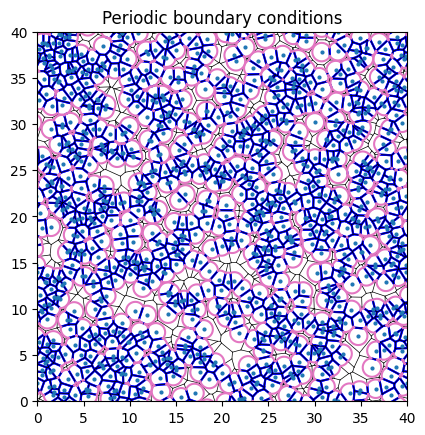

In [7]:
fig, ax = plt.subplots(dpi=100)
ax = sim.plot_2d()

ax.set_xlim(0, L)
ax.set_ylim(0, L)
ax.set_title("Periodic boundary conditions")

plt.show()

In [8]:
def custom_plot_2d(pts: np.ndarray, diag: dict, r: float, ax=None):
    """
    Custom plot function
    """
    if ax is None:
        ax = plt.gca()
    
    point_edges_type = diag["edges_type"]
    point_vertices_f_idx = diag["regions"]
    vertices_all = diag["vertices"]

    # Draw cell centers
    # ax.plot(pts[:, 0], pts[:, 1], 'o', color='C0', markersize=2, zorder=3)

    N = len(pts)

    # Draw each cell boundary
    for idx in range(N):
        edges_type = point_edges_type[idx]
        vertices_f_idx = point_vertices_f_idx[idx]

        x, y = pts[idx]
        if len(edges_type) < 2:
            angle = np.linspace(0, 2*np.pi, 100)
            ax.plot(x + r * np.cos(angle), y + r * np.sin(angle), color="C2", lw=1., zorder=1)
            ax.fill(x + r * np.cos(angle), y + r * np.sin(angle), color="C2", alpha=0.1, zorder=0)
            continue

        for idx_f, edge_type in enumerate(edges_type):
            v1_idx = vertices_f_idx[idx_f]
            x1, y1 = vertices_all[v1_idx]
            idx2 = idx_f + 1 if idx_f < len(edges_type)-1 else 0
            v2_idx = vertices_f_idx[idx2]
            x2, y2 = vertices_all[v2_idx]

            if edge_type == 1:
                ax.plot([x1, x2], [y1, y2], color="C0", lw=1., zorder=2)
                ax.fill([x1, x2, x], [y1, y2, y], 'C2', alpha=0.1, zorder=0)
            else:
                angle1 = np.arctan2(y1-y, x1-x)
                angle2 = np.arctan2(y2-y, x2-x)
                dangle = np.linspace(0, (angle1 - angle2) % (2*np.pi), 100)

                ax.plot(x + r * np.cos(angle2+dangle), y + r * np.sin(angle2+dangle), color="C2", lw=1., zorder=1)
                ax.fill(np.append(x + r * np.cos(angle2+dangle), x), np.append(y + r * np.sin(angle2+dangle), y), color="C2", alpha=0.1, lw=0, zorder=0)

    ax.set_aspect("equal")
    return ax

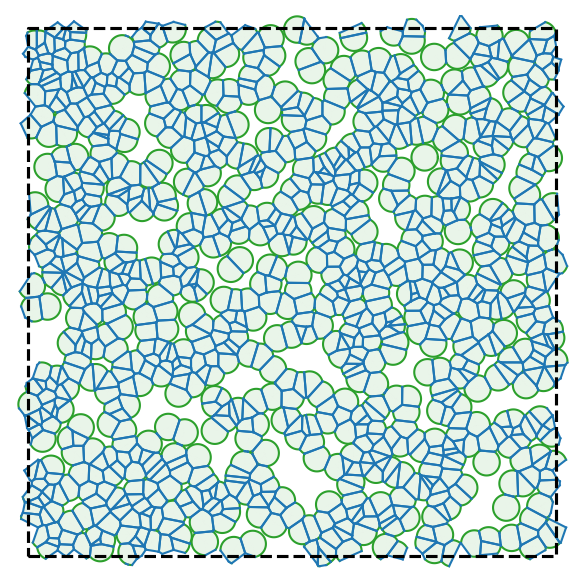

In [9]:
diag = sim.build()

# Plot the first N cells
fig, ax = plt.subplots(dpi=150)
ax = custom_plot_2d(pts, diag, radius)
ax.tick_params(axis='both', length=0, labelbottom=False, labelleft=False)
ax.axis('off')   # <- hides ticks, labels, and spines

ax.plot([0, L, L, 0, 0], [0, 0, L, L, 0], 'k--')
ax.set_xlim(-radius, L+radius)
ax.set_ylim(-radius, L+radius)
# plt.savefig('pbc.png', dpi=300, bbox_inches='tight')

plt.show()

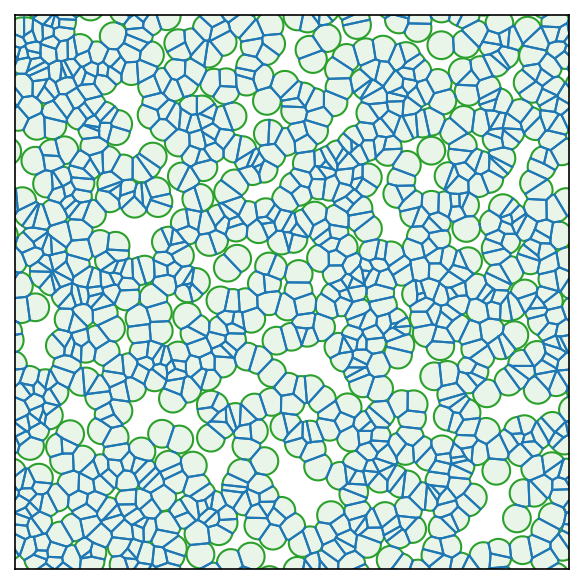

In [10]:
# Plot all cells
fig, ax = plt.subplots(dpi=150)
ax = custom_plot_2d(pts_pbc, diag, radius)
ax.tick_params(axis='both', length=0, labelbottom=False, labelleft=False)
ax.set_xlim(0, L)
ax.set_ylim(0, L)
plt.show()